ideas for green output: consumption_renewable/consumption_non

primary energy consumption relate to carbon intensity





In [5]:
# Import necessary libraries

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from prettytable import PrettyTable
from collections import Counter
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.sparse import hstack

import re
import tqdm
from tqdm.notebook import tqdm

import json
import time
import sys

from tenacity import retry, wait_exponential
tqdm.pandas()
from sklearn import preprocessing

In [37]:
# Import dataset
df = pd.read_csv("World Energy Consumption.csv")

In [38]:
# A helpful method for creating dictionarys with lists or other objects that don't point to the same object/list
def makedict(keys = [], values=list()):
  result = {}
  for key in keys:
    result[key] = values.copy()
  return result

In [39]:
# Build the two classifier datasets - one which contains data about country's fuel consumption and one about electricity production using the keywords
categories_to_analyze = ['consumption','_electricity'] # to add a value, add entry to list
# have default columns for the regressors
defaultColumns = ['country', 'year', 'greenhouse_gas_emissions','status']
  # get all the consumption from sources columns
  # get all the electricity from sources columns

# Make a dictionary of two lists which hold the columns for consumption and electricity
categories = makedict(keys=categories_to_analyze, values=list())
for column in df.columns:
  for key in categories.keys():
    if key in column:
      categories[key].append(column)

# add the default columns to the lists of consumption and electricity columns
for key in categories.keys():
  categories[key].extend(defaultColumns)

# make a dictionary of two dataframes
category_df = makedict(keys=categories_to_analyze, values=pd.DataFrame())

high-income economies are those with a GNI per capita of $13,846 or more. - from https://datahelpdesk.worldbank.org/knowledgebase/articles/906519

In [40]:
# tag countries in the dataset with develop or developing
df['GDP_per_capita'] = df['gdp'] / df['population']
# set the developing or developed country status
df['status'] = df['GDP_per_capita'] > 13846
for index, entry in df['status'].items():
  if entry == True:
    df.loc[index, 'status'] = 'developed'
  else:
    df.loc[index, 'status'] = 'developing'
# drop all empty rows
df_for_class = df.dropna()
# print the gdp per capita for sanity check
print(df_for_class['GDP_per_capita'])

1071     20133.795316
1072     19722.488106
1073     19989.139448
1074     19287.777078
1075     19600.382495
             ...     
20702    51183.112519
20703    52070.841334
20704    52451.297607
20705    53355.875756
20706    54617.324779
Name: GDP_per_capita, Length: 194, dtype: float64


In [41]:
# Print the categories aka the consumption and electricity columns for examination
print(categories)

{'consumption': ['biofuel_consumption', 'coal_consumption', 'fossil_fuel_consumption', 'gas_consumption', 'hydro_consumption', 'low_carbon_consumption', 'nuclear_consumption', 'oil_consumption', 'other_renewable_consumption', 'primary_energy_consumption', 'renewables_consumption', 'solar_consumption', 'wind_consumption', 'country', 'year', 'greenhouse_gas_emissions', 'status'], '_electricity': ['biofuel_electricity', 'coal_electricity', 'fossil_electricity', 'gas_electricity', 'hydro_electricity', 'low_carbon_electricity', 'nuclear_electricity', 'oil_electricity', 'other_renewable_electricity', 'other_renewable_exc_biofuel_electricity', 'per_capita_electricity', 'renewables_electricity', 'solar_electricity', 'wind_electricity', 'country', 'year', 'greenhouse_gas_emissions', 'status']}


<Axes: xlabel='year', ylabel='greenhouse_gas_emissions'>

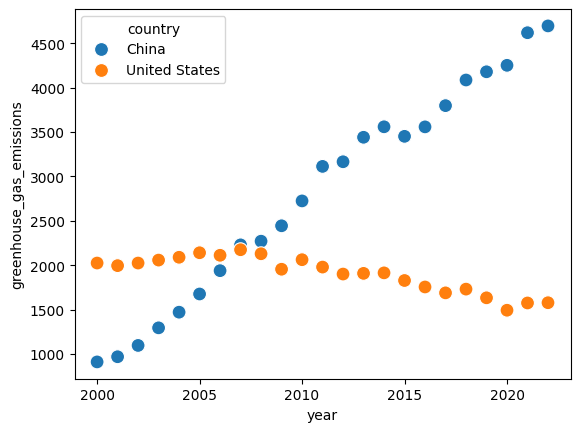

In [42]:
# Create a scatter plot of the US and China emissions over time for understanding the data
plot_df = df[defaultColumns].copy()
countries = ['United States', 'China']
years = range(2000,2023)
rows = plot_df[(plot_df['country'].isin(countries)) & (plot_df['year'].isin(years))]
sns.scatterplot(x='year',                       # X-axis - label must match that of the df
                y='greenhouse_gas_emissions',   # Y-axis - label must match that of the df
                hue='country',
                s=100,
                data=rows)

In [12]:
# Show developed countries for sanity check - I guess Algeria is fine...
display(df[df['status']=='developed'])

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy,GDP_per_capita,status
703,Algeria,2015,DZA,39543148.0,5.515190e+11,NaN,NaN,NaN,NaN,0.0,...,1800.000,0.048,0.051,0.506,0.020,1.294,0.031,0.008,13947.270966,developed
704,Algeria,2016,DZA,40339328.0,5.746960e+11,NaN,NaN,NaN,NaN,0.0,...,0.274,0.000,0.051,0.744,0.030,1.264,0.045,0.008,14246.543720,developed
705,Algeria,2017,DZA,41136548.0,5.821670e+11,NaN,NaN,NaN,NaN,0.0,...,-0.273,0.000,0.051,0.243,0.010,1.229,0.014,0.008,14152.062541,developed
706,Algeria,2018,DZA,41927008.0,5.903180e+11,NaN,NaN,NaN,NaN,0.0,...,-47.368,-0.024,0.026,0.239,0.010,0.631,0.014,0.004,14079.659584,developed
1057,Argentina,1997,ARG,35815968.0,5.315260e+11,NaN,NaN,NaN,NaN,NaN,...,51.716,0.015,0.043,0.407,0.015,1.205,0.020,0.006,14840.475622,developed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12476,Montenegro,2014,MNE,634301.0,1.020567e+10,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,0.000,0.000,NaN,0.000,NaN,16089.628312,developed
12477,Montenegro,2015,MNE,633969.0,1.068959e+10,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,0.000,0.000,NaN,0.000,NaN,16861.368856,developed
12478,Montenegro,2016,MNE,633264.0,1.096616e+10,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,0.000,0.000,NaN,0.000,NaN,17316.877738,developed
12479,Montenegro,2017,MNE,632445.0,1.144381e+10,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,158.117,0.100,NaN,4.032,NaN,18094.547681,developed


In [13]:
# This blokc will remove entities from the dataset that are not countries
from sklearn.model_selection import KFold
import math
from sklearn.metrics import mean_squared_error as mse
from collections import OrderedDict
import statistics as stats
topEmissions = {}
Countries = []
# keywords we found that are part of the names of entities that are not countries
NoInclude = ['Ember', 'World', 'countries','Asia','Africa',
             'Europe', 'Antarctica', '(EIA)', '(SHIFT)',
             'Middle East', 'country', '(EI)', 'USSR',
             'North America', 'South America', 'Oceania']

# go thru the countries in the dataframe and remove any non-country entities
for c in df['country'].unique():
  if any(n.lower() in c.lower() for n in NoInclude):
    continue
  else:
    Countries.append(c)

# calculate the average emissions from every country for all data available
# This will allow us to rank the countries in the dataset
for c in Countries:
  workingData = df[(df.country == c)]['greenhouse_gas_emissions']
  workingData = workingData.dropna()
  if workingData.size > 1:
    topEmissions[stats.mean(workingData)] = c

In [14]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
# a method for analyzing the performance an ML model
def confusionMat(y_test, y_pred):
    # get the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # make and plot the CF
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Test Confusion Matrix')
    # print the performance
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("f1 score:", f1_score(y_test, y_pred, average='weighted'))
    print("precision", precision_score(y_test, y_pred, average='weighted'))
    print("recall", recall_score(y_test, y_pred, average='weighted'))
    plt.show()
    print()

,biofuel_consumption,coal_consumption,fossil_fuel_consumption,gas_consumption,hydro_consumption,low_carbon_consumption,nuclear_consumption,oil_consumption,other_renewable_consumption,primary_energy_consumption,renewables_consumption,solar_consumption,wind_consumption,country,year,greenhouse_gas_emissions,status
1070,5.923,13.472,761.782,420.874,92.593,122.187,19.203,327.436,4.397,883.969,102.984,0.000,0.070,Argentina,2010,43.89,developed
1071,8.673,14.619,792.928,438.398,86.034,116.163,16.942,339.912,4.436,909.091,99.221,0.004,0.073,Argentina,2011,47.15,developed
1072,10.397,13.669,830.823,456.642,79.967,112.884,16.845,360.511,4.639,943.706,96.039,0.022,1.014,Argentina,2012,50.70,developed
1073,11.902,14.939,857.796,460.277,89.316,123.602,16.233,382.580,4.874,981.398,107.369,0.041,1.236,Argentina,2013,50.90,developed
1074,13.891,15.892,857.357,461.550,87.820,122.501,14.334,379.916,4.733,979.858,108.166,0.043,1.678,Argentina,2014,50.91,developed


448
Accuracy 0.9111111111111111
f1 score: 0.9107208774982861
precision 0.9107598978288634
recall 0.9111111111111111


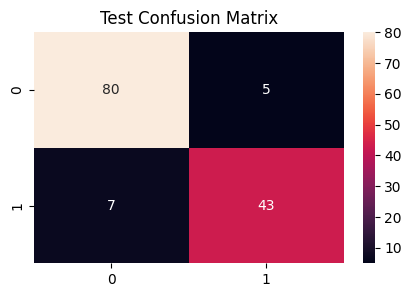

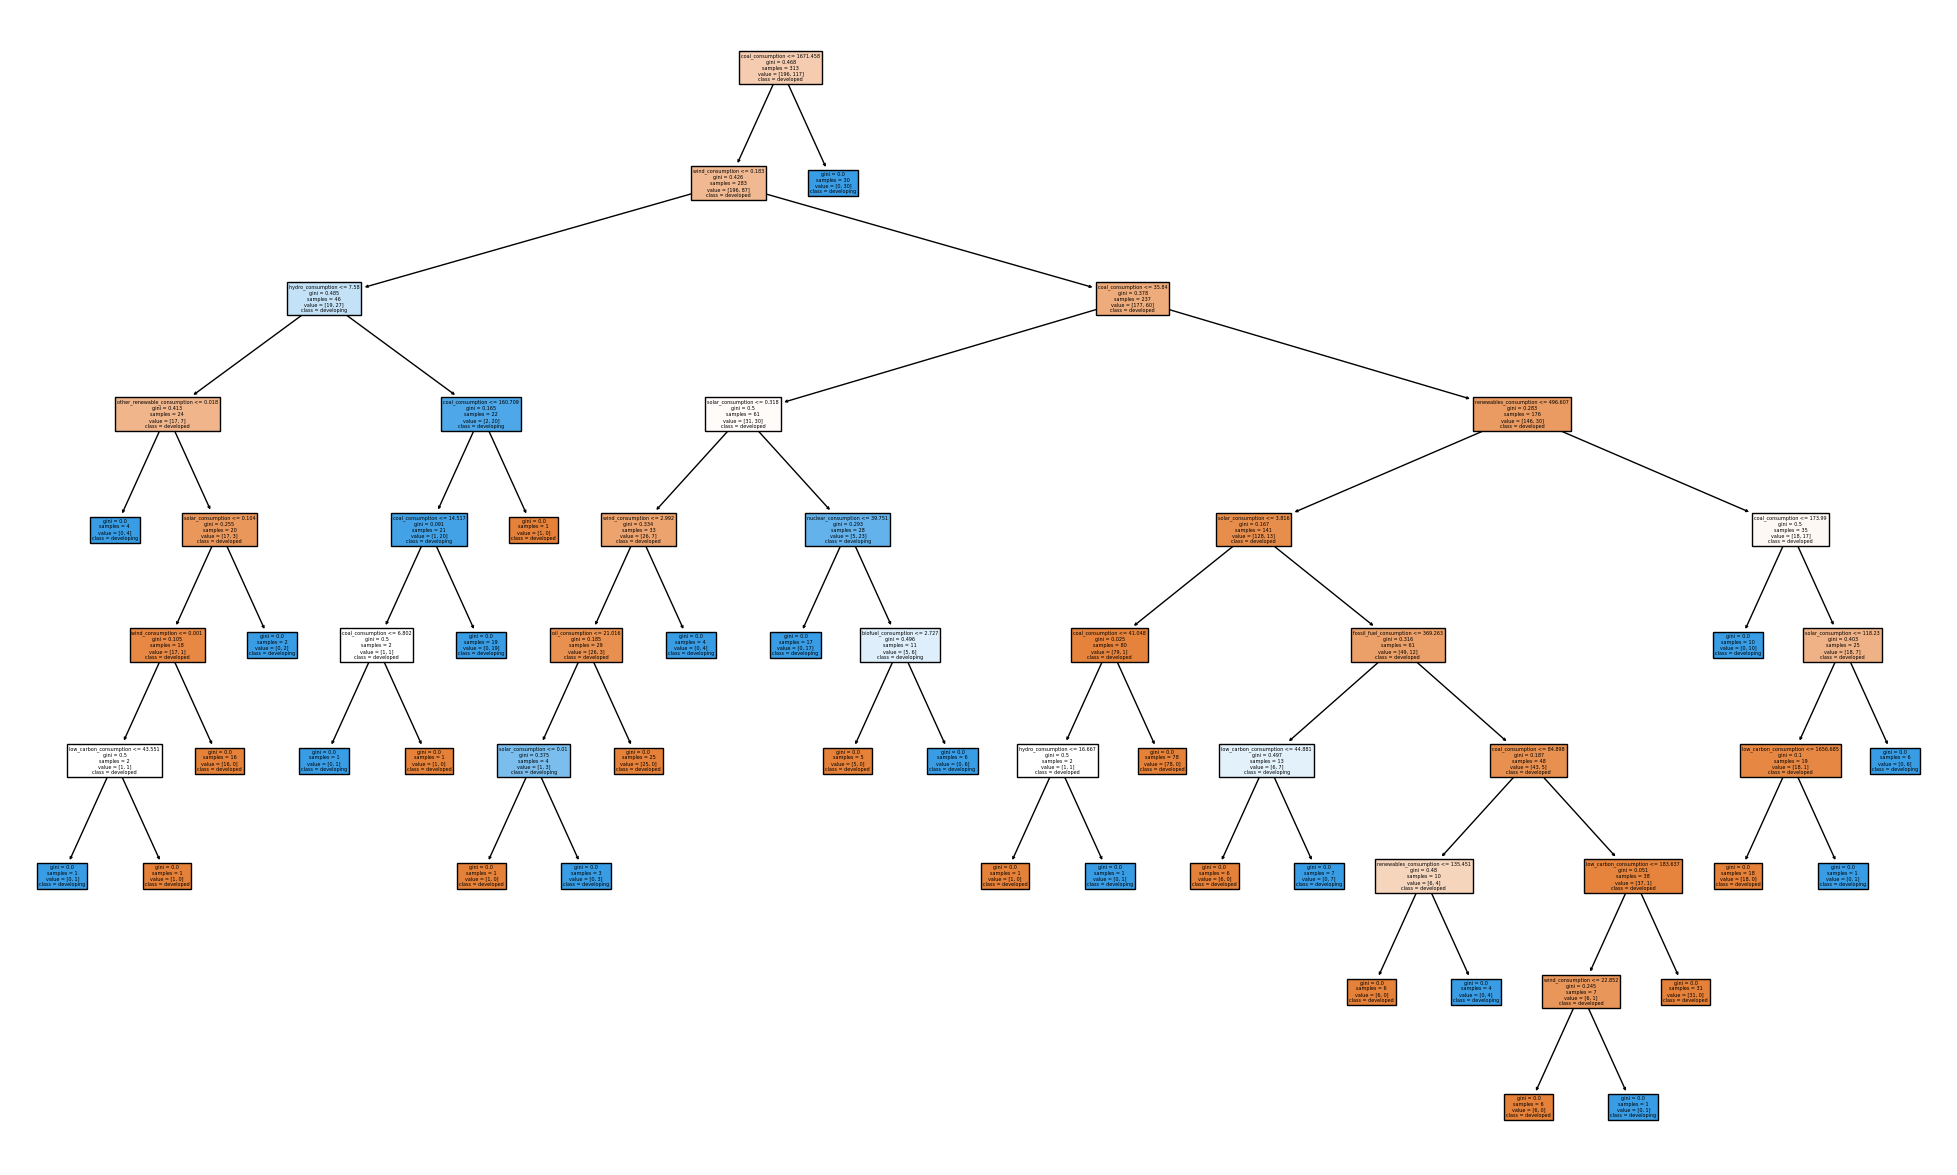

,biofuel_electricity,coal_electricity,fossil_electricity,gas_electricity,hydro_electricity,low_carbon_electricity,nuclear_electricity,oil_electricity,other_renewable_electricity,other_renewable_exc_biofuel_electricity,per_capita_electricity,renewables_electricity,solar_electricity,wind_electricity,country,year,greenhouse_gas_emissions,status
123,0.0,0.0,0.16,0.0,0.31,0.31,0.0,0.16,0.0,0.0,24.050,0.31,0.0,0.0,Afghanistan,2000,0.12,developing
124,0.0,0.0,0.09,0.0,0.50,0.50,0.0,0.09,0.0,0.0,29.967,0.50,0.0,0.0,Afghanistan,2001,0.07,developing
125,0.0,0.0,0.13,0.0,0.56,0.56,0.0,0.13,0.0,0.0,32.857,0.56,0.0,0.0,Afghanistan,2002,0.10,developing
126,0.0,0.0,0.31,0.0,0.63,0.63,0.0,0.31,0.0,0.0,41.510,0.63,0.0,0.0,Afghanistan,2003,0.24,developing
127,0.0,0.0,0.33,0.0,0.56,0.56,0.0,0.33,0.0,0.0,37.786,0.56,0.0,0.0,Afghanistan,2004,0.24,developing


2693
Accuracy 0.9195544554455446
f1 score: 0.9185814165622848
precision 0.9182440706995969
recall 0.9195544554455446


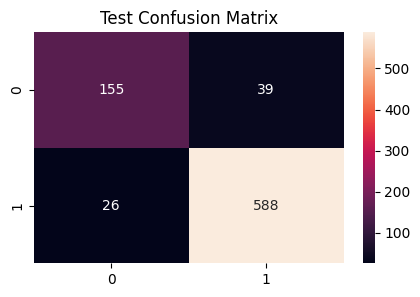

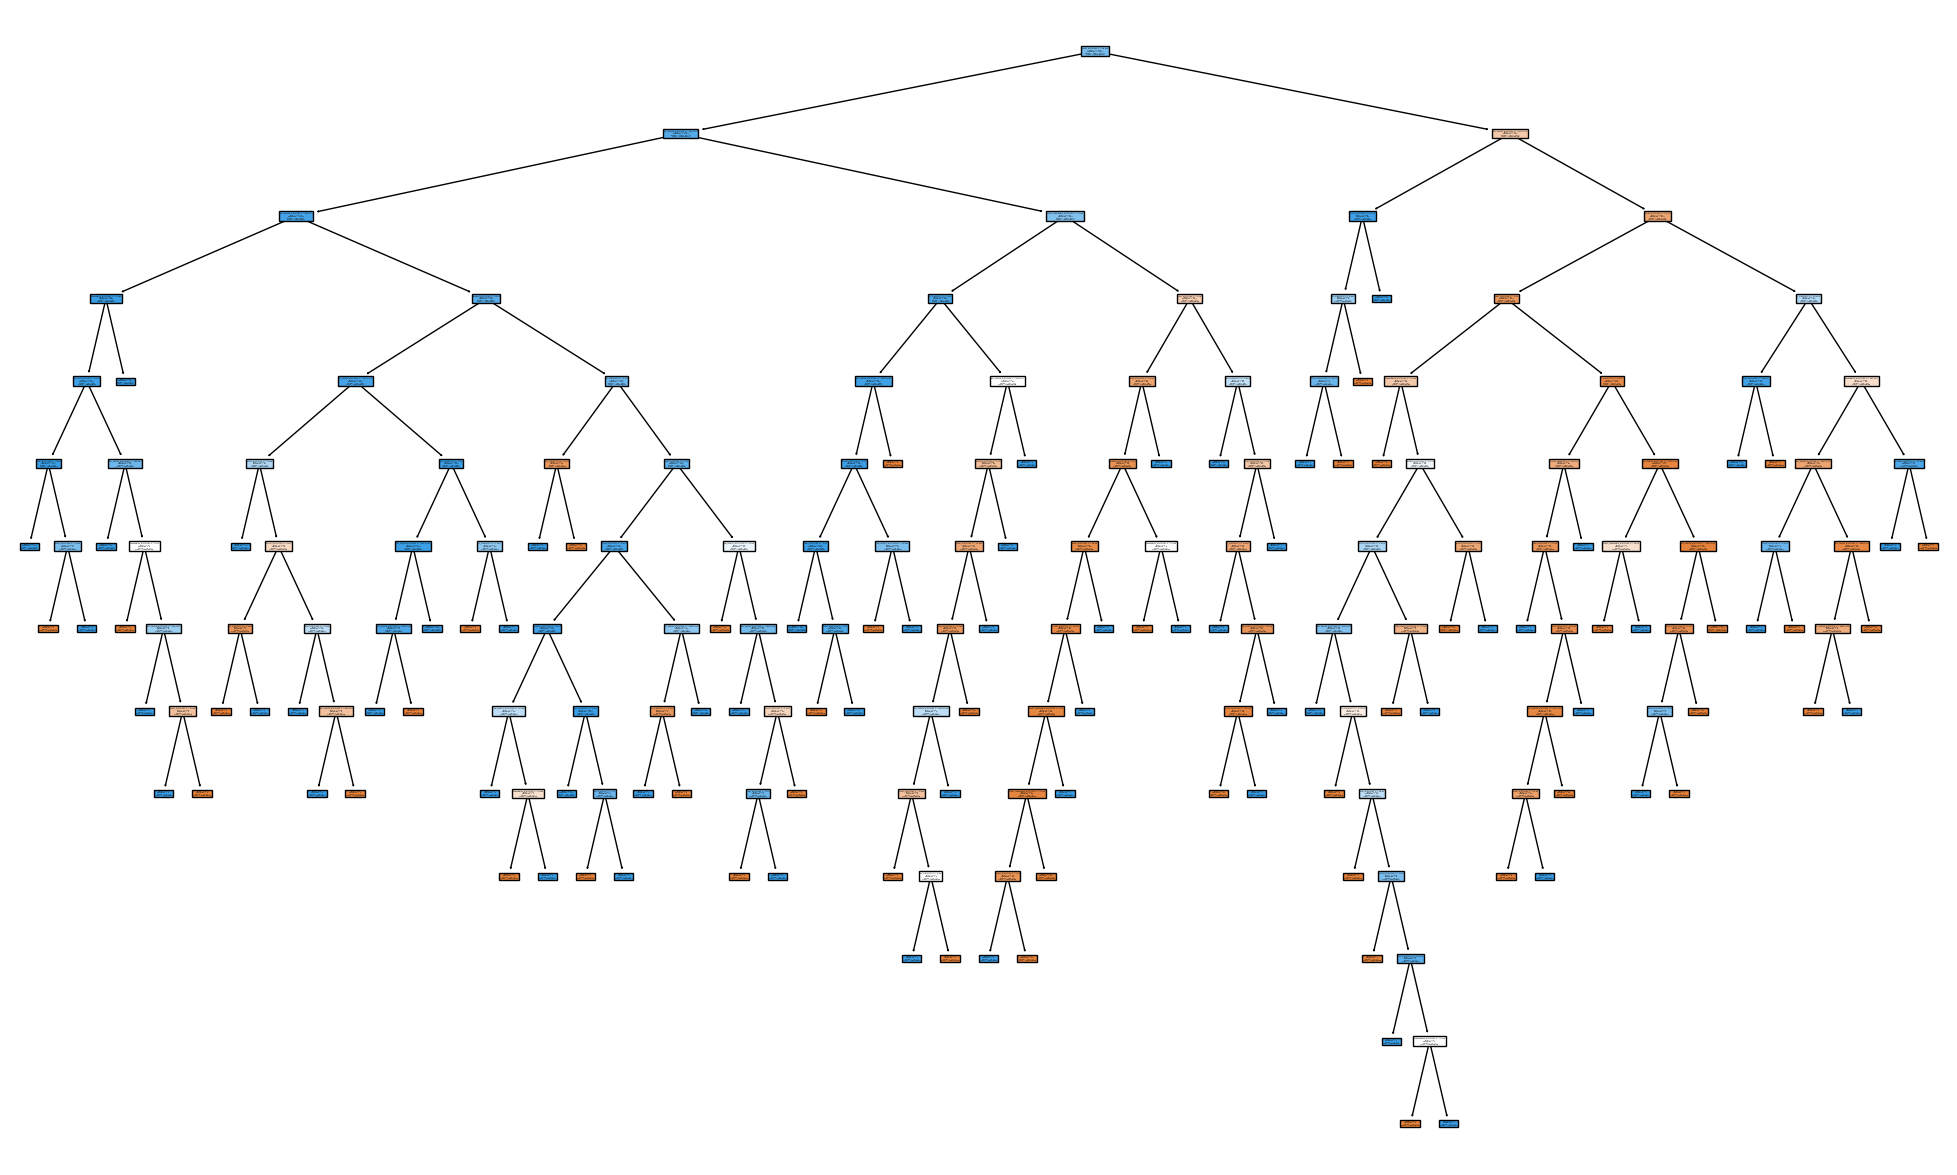

In [15]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Go thru & set up the two category based dataframes
for key in categories.keys():
  # copy the category data from the main dataframe
  category_df[key]=df[categories[key]].copy()
  # select the countries we want
  category_df[key]=category_df[key][category_df[key]['country'].isin(Countries)]
  # drop all empty rows
  category_df[key].dropna(inplace=True)
  display(category_df[key].head())
  # create the train and test data
  X_data = category_df[key].drop(columns=['status','country','year','greenhouse_gas_emissions'])
  Y_data = category_df[key]['status']
  x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, stratify=Y_data, test_size=0.30, train_size=0.70)
  # show how many samples we have
  print(Y_data.count())
  # create and fit the tree
  DT = DecisionTreeClassifier(random_state=1)
  DT.fit(x_train, y_train)
  # predict the test set's target class (i.e., whether each patient will have a cancer or not), and then report accuracy
  y_pred = DT.predict(x_test)
  # show a confusion matrix of the results
  confusionMat(y_test, y_pred)
  # show the decision tree and save the image
  plt.figure(figsize=(25,15))
  treePlot = tree.plot_tree(DT, filled=True, feature_names=category_df[key].columns, class_names=Y_data.unique())
  plt.savefig(f'DT{key}.png', dpi = 1200)
  plt.show()

In [16]:
# get the top 20 countries emissions
top20 = sorted(list(topEmissions.keys()), reverse=True)[:20]

In [17]:
topCountries = {}
# get the top 20 countries based on emissions
for emissions in top20:
  topCountries[topEmissions[emissions]]=emissions

In [18]:
display(topCountries)

{'China': 2823.6717391304346,
 'India': 701.3921739130435,
 'Japan': 481.0221739130435,
 'Germany': 275.86434782608694,
 'Australia': 151.61913043478262,
 'Italy': 125.59739130434782,
 'Mexico': 124.05260869565217,
 'Indonesia': 121.36478260869565,
 'Iran': 120.66695652173914,
 'Canada': 102.63304347826087,
 'Malaysia': 72.23086956521739,
 'Egypt': 70.10260869565218,
 'Brazil': 59.49,
 'Kazakhstan': 57.54304347826087,
 'France': 42.44608695652174,
 'Argentina': 42.10521739130435,
 'Czechia': 40.89826086956522,
 'Israel': 35.115,
 'Greece': 32.45739130434782,
 'Iraq': 27.98090909090909}

In [19]:
# get the top 20 emission producing country's data
df_top = df[df['country'].isin(list(topCountries.keys()))]

In [20]:
display(df_top)

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy,GDP_per_capita,status
960,Argentina,1900,ARG,4685089.0,2.150802e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4590.738442,developing
961,Argentina,1901,ARG,4855502.0,2.237194e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4607.544678,developing
962,Argentina,1902,ARG,5036658.0,2.191486e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4351.071588,developing
963,Argentina,1903,ARG,5229108.0,2.505633e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4791.701688,developing
964,Argentina,1904,ARG,5428911.0,2.774413e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5110.440938,developing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11927,Mexico,2018,MEX,124013864.0,2.006600e+12,11.639,0.255,19.687,2.441,60.477,...,17.095,4.638,32.900,101.037,12.53,265.295,3.774,1.452,16180.448986,developed
11928,Mexico,2019,MEX,125085312.0,NaN,10.425,0.255,21.553,2.696,53.164,...,34.512,11.191,44.092,134.148,16.78,352.493,5.275,1.969,NaN,developing
11929,Mexico,2020,MEX,125998296.0,NaN,9.443,0.255,23.417,2.951,54.525,...,17.792,7.654,51.745,156.907,19.77,410.684,6.073,2.507,NaN,developing
11930,Mexico,2021,MEX,126705136.0,NaN,-13.960,-0.412,20.036,2.539,53.431,...,6.963,3.401,55.146,165.502,20.97,435.232,6.223,2.485,NaN,developing


In [21]:
# define a simple pytorch NN regression model
import torch
# select the gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',  device)
# define the model
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.gelu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

# sort the data for graphing
def combinedlistsorting(train, prediction):
    combined_lists = list(zip(train, prediction))

    sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0])

    sorted_list1, sorted_list2 = zip(*sorted_combined_lists)
    return sorted_list1, sorted_list2

device: cpu


Loss 0.62180096


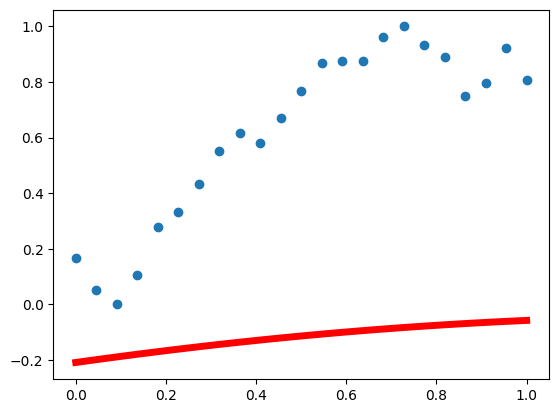

Loss 0.01870221


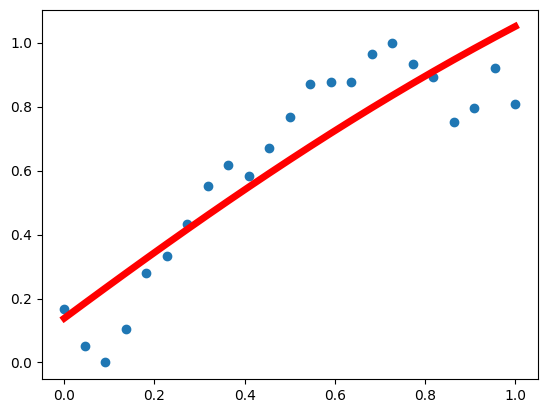

Loss 0.016291514


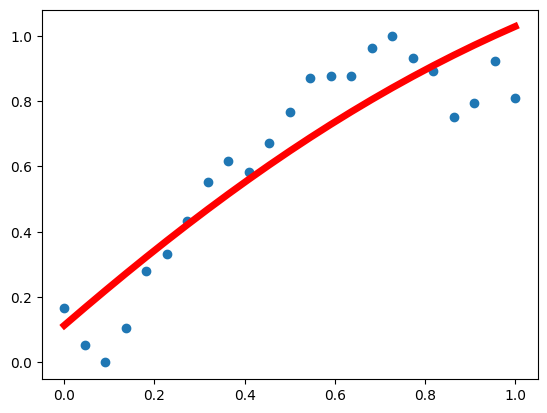

Loss 0.013694299


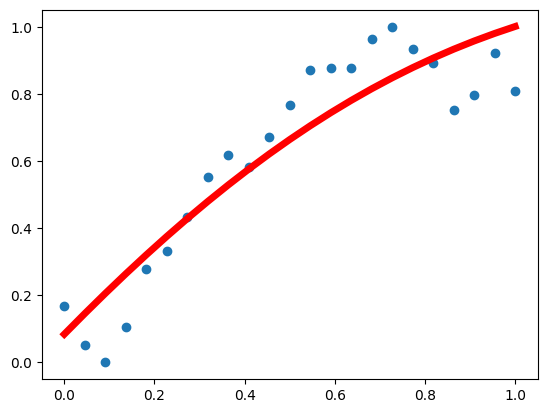

Loss 0.011209355


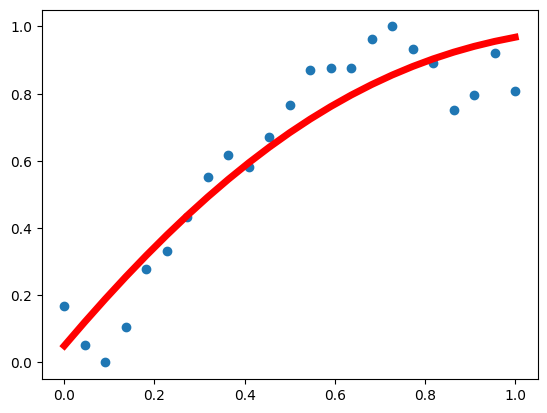

Loss 0.009314018


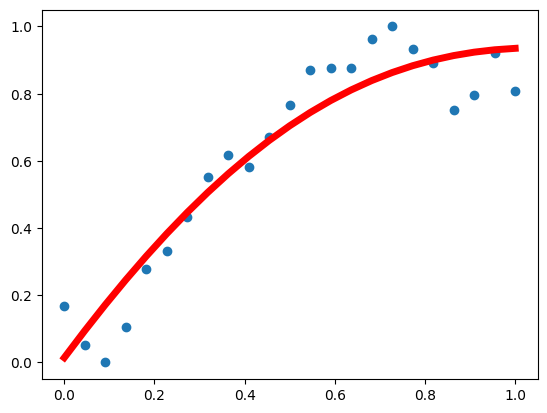

3
3
Loss 0.75028723


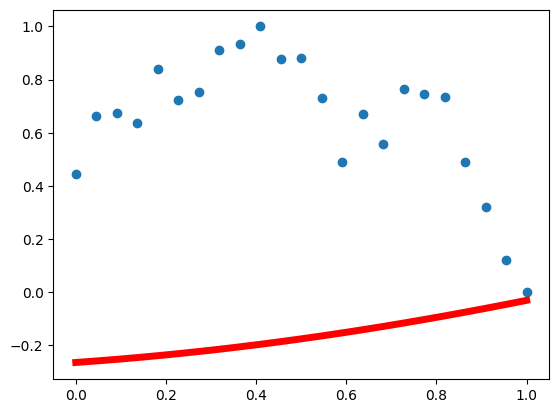

KeyboardInterrupt: 

In [44]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
yearToProject = 2040
countryStats = makedict(keys = topCountries.keys(), values=makedict(keys=[1,2,3,4,'DNN'], values = list()))

# select only the regression relevant data
workingData = df_top[['country','greenhouse_gas_emissions','year']]
workingData = workingData.dropna()
# make all original data not regression
workingData['Regression'] = False
# make all original data of degree 0
workingData['Degree'] = '0'
# workingData['Best']= False

# run the regression algorithms on each country
for country in workingData['country'].unique():
  # select all available years
  years = np.array(workingData[workingData.country == country]['year'])
  # select all available emissions
  emissions = np.array(workingData[workingData.country == country]['greenhouse_gas_emissions']).reshape(-1,1)
  # determine all future datapoints to predict
  toPred = range(int(sorted(list(years),reverse=True)[0] + 1), yearToProject, 1)
  # reshape inputs to work with a regression model
  years = years.reshape(-1,1)
  toPred = np.array(toPred).reshape(-1,1)

  # run the regressions
  for degree in [1,2,3,4]:
    # instatiate the model
    LinReg = LinearRegression()
    # make the years fit to polynomials & ready to input to a regression
    poly = PolynomialFeatures(degree=degree)
    yearsPoly = poly.fit_transform(years)
    toPredPoly = poly.transform(toPred)
    # fit the model
    LinReg.fit(yearsPoly, emissions)
    # get the training R2, RMSE and store them along with the most recent given data year & fit the model
    train_R2 = LinReg.score(yearsPoly, emissions)
    train_RMSE = mean_squared_error(LinReg.predict(yearsPoly), emissions)
    countryStats[country][degree]=[train_R2, train_RMSE, toPred[0][0]]

    # add the predicted data to the dataframe
    new_rows = pd.DataFrame([(country, str(degree), year[1], LinReg.predict([year])[0][0], True) for year in toPredPoly], columns=['country', 'Degree','year', 'greenhouse_gas_emissions', 'Regression'])
    workingData = pd.concat([workingData, new_rows], ignore_index=True)
    workingData = workingData.sort_values(by=['country', 'year']).reset_index(drop=True)

  # normalize years and emissions with min-max
  years_min = years.min(axis=0)  # Compute the minimum value for each column
  years_max = years.max(axis=0)  # Compute the maximum value for each column
  years_normalized = (years - years_min) / (years_max - years_min) # min max normalize the years for the NN

  emissions_min = emissions.min(axis=0)  # Compute the minimum value for each column
  emissions_max = emissions.max(axis=0)  # Compute the maximum value for each column
  emissions_normalized = (emissions - emissions_min) / (emissions_max - emissions_min) # min max normalize the emissions for the NN

  # convert to tensors
  years = torch.from_numpy(years_normalized).float().to(device)
  emissions = torch.from_numpy(emissions_normalized).float().to(device)

  # define the network
  net = Net(n_feature=1, n_hidden=20, n_output=1)
  optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
  loss_func = torch.nn.MSELoss()
  net.to(device)

  for t in range(600): # number of epoches
    prediction = net(years)     # input x and predict based on x
    loss = loss_func(prediction, emissions)     # must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if t % 100 == 0:
      # plot and show learning process
      plt.cla()
      plt.scatter(years.cpu().data.numpy(), emissions.cpu().data.numpy())
      sortedtrain, sortedprediction = combinedlistsorting(years.cpu().data.numpy(), prediction.cpu().data.numpy())
      plt.plot(sortedtrain, sortedprediction, 'r-', lw=5)
      print("Loss", loss.cpu().data.numpy())
      plt.pause(0.1)

  prediction_calc_loss = net(years)     # input x and predict based on x
  countryStats[country]['DNN'] = [r2_score(emissions, prediction_calc_loss.detach().cpu().numpy()), toPred[0][0]]     # must be (1. nn output, 2. target)
  # normalize the years to predict based on the normalization values from above
  toPred_normalized = (toPred - years_min) / (years_max - years_min)
  # get predictions
  predictions = net(torch.from_numpy(toPred_normalized).float().to(device))
  # de-normalize the emissions predictions
  predictions = predictions.detach().cpu().numpy() * (emissions_max - emissions_min) + emissions_min
  # add data to dataframe
  new_rows = pd.DataFrame([(country, 'DNN', year[0], predictions[year[0]-toPred[0][0]][0], True) for year in toPred], columns=['country', 'Degree','year', 'greenhouse_gas_emissions', 'Regression'])
  workingData = pd.concat([workingData, new_rows], ignore_index=True)
  workingData = workingData.sort_values(by=['country', 'year']).reset_index(drop=True)

  # get best fit model based on R2 - perhaps could overfit, but we understand as such
  best = 1
  for regression_algo in list(countryStats[country].keys()):
    if countryStats[country][best][0] < countryStats[country][regression_algo][0]:
      best = regression_algo
  print(best)
  print(str(best))
  # add best prediction to dataframe with degree 'Best'
  new_rows = workingData[(workingData['Degree'] == str(best)) & (workingData['country']==country)].copy()
  new_rows['Degree'] = 'Best'
  workingData = pd.concat([workingData, new_rows], ignore_index=True)
  workingData = workingData.sort_values(by=['country', 'year']).reset_index(drop=True)
  # workingData[workingData['Degree']=='Best']['Best'] = True
  # compare R2 scores and pick best predictor model




In [23]:
display(workingData[workingData['Degree']=='Best'])

,country,greenhouse_gas_emissions,year,Regression,Degree
28,Argentina,43.315731,2023.0,True,Best
34,Argentina,39.422480,2024.0,True,Best
40,Argentina,34.779905,2025.0,True,Best
46,Argentina,29.346465,2026.0,True,Best
52,Argentina,23.080615,2027.0,True,Best
...,...,...,...,...,...
2485,Mexico,73.310670,2035.0,True,Best
2491,Mexico,62.216970,2036.0,True,Best
2497,Mexico,50.097923,2037.0,True,Best
2503,Mexico,36.917130,2038.0,True,Best


In [24]:
display(workingData[workingData['Degree']=='Best'].count())

country                     342
greenhouse_gas_emissions    342
year                        342
Regression                  342
Degree                      342
dtype: int64

In [25]:
# Here is the end to our progress report...

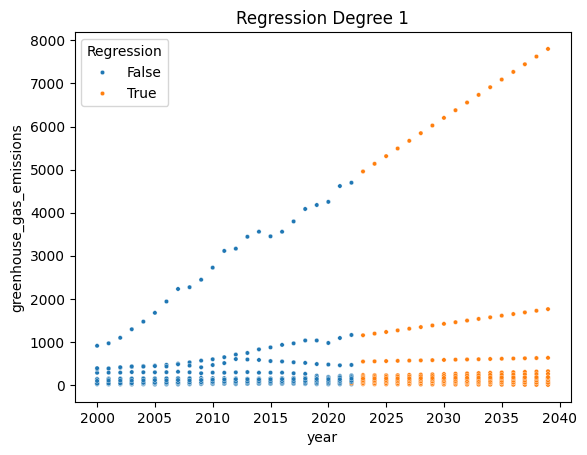

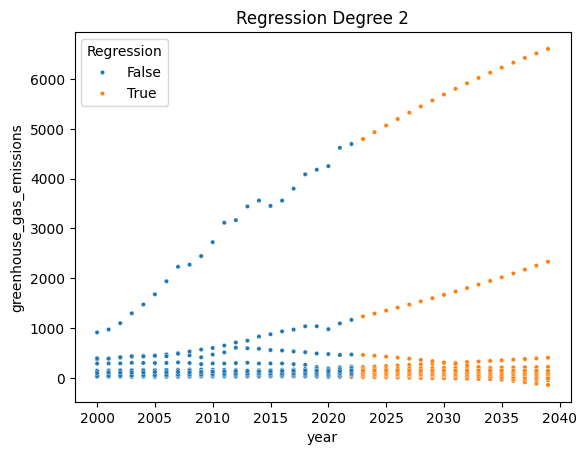

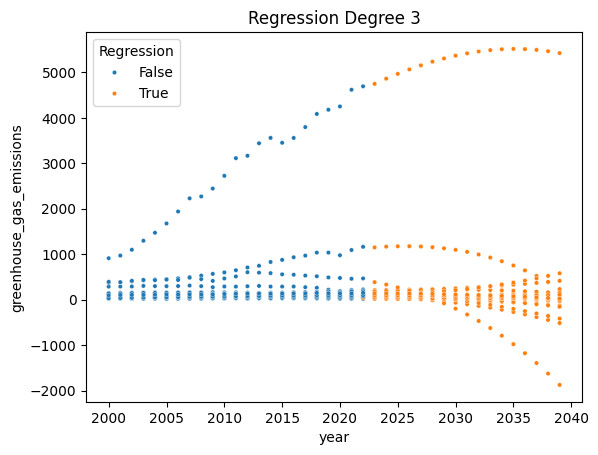

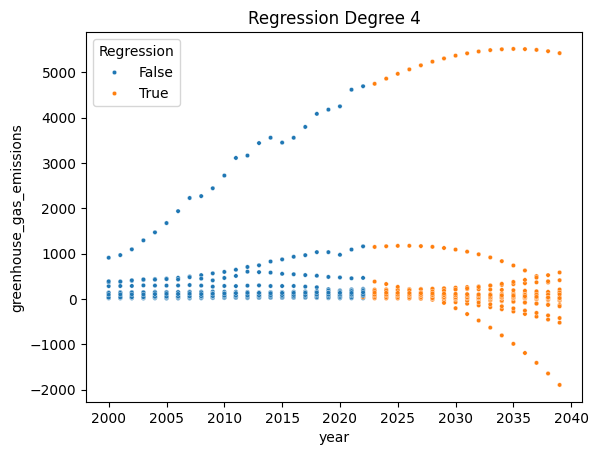

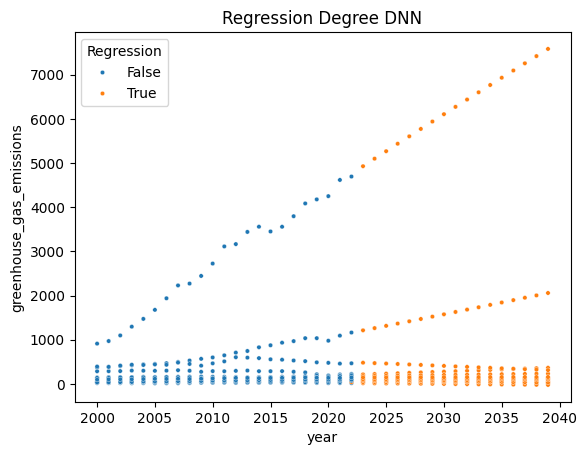

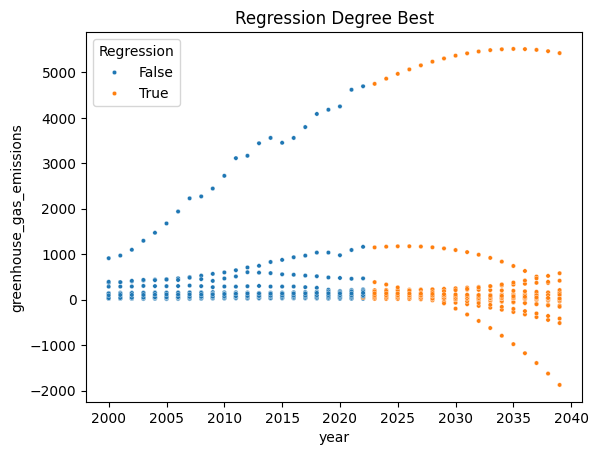

In [26]:
# Create a scatter plot of the top 20 countries different regressions
defaultColumns = ['country', 'year', 'greenhouse_gas_emissions', 'Regression', 'Degree']
plot_df = workingData[defaultColumns].copy()
# save the data for the tableau
plot_df.to_csv('country_data.csv')
countries = workingData.country.unique()
# plot relevant data
years = range(2000,2040)
for degree in [1, 2, 3, 4, 'DNN','Best']:
  rows = plot_df[(plot_df['country'].isin(countries)) & (plot_df['year'].isin(years)) & (plot_df['Degree'].isin([str(0),str(degree)]))]
  sns.scatterplot(x='year',                       # X-axis - label must match that of the df
                  y='greenhouse_gas_emissions',   # Y-axis - label must match that of the df
                  hue='Regression',
                  s=10,
                  data=rows)
  plt.title(f'Regression Degree {degree}')
  plt.show()

In [27]:
# sum the data for each year for each degree to get the world emissions per year for each degree
world_emissions = workingData.groupby(['year','Degree'])['greenhouse_gas_emissions'].sum().reset_index()
display(world_emissions)
world_emissions['country'] = 'world'
world_emissions['Regression'] = world_emissions['year'] > 2021 # this magic number is based on Saudia arabia having the most recent data in 2021, thus everything after is a regression
# go through the years and if a specific year has both regressions and given data, add the given data to the regression and label the point as regression
# otherwise there is a point that is just the emissions from Saudi Arabia in 2022 because all other countries have data from 2022 - bit of a complex problem
for year in world_emissions.year.unique():
  degrees = world_emissions[world_emissions['year']==year].Degree.unique()
  if '0' in degrees and len(degrees)>1:
    temp = world_emissions[world_emissions['year']==year]
    for i in range(1, len(degrees)):
      temp.loc[temp['Degree'] == degrees[i], 'greenhouse_gas_emissions'] = temp.loc[temp['Degree'] == '0','greenhouse_gas_emissions'].item() + temp.loc[temp['Degree'] == degrees[i], 'greenhouse_gas_emissions'].item()
    world_emissions[world_emissions['year']==year] = temp

,year,Degree,greenhouse_gas_emissions
0,2000.0,0,2909.770000
1,2001.0,0,3003.870000
2,2002.0,0,3208.030000
3,2003.0,0,3485.300000
4,2004.0,0,3713.880000
...,...,...,...
126,2039.0,2,10091.555946
127,2039.0,3,4164.983665
128,2039.0,4,4119.729299
129,2039.0,Best,4141.733641


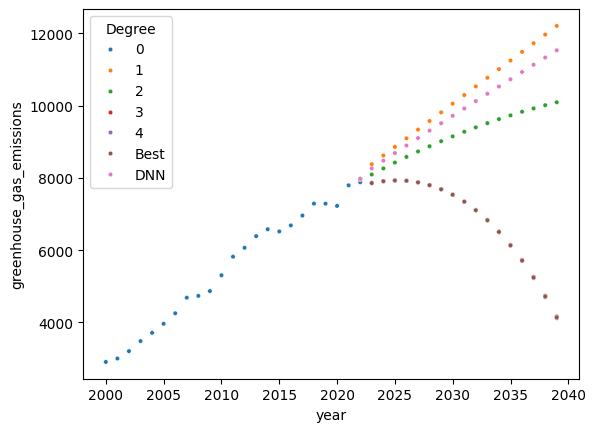

In [28]:
# Create a scatter plot of all the regressions
sns.scatterplot(x='year',                       # X-axis - label must match that of the df
                y='greenhouse_gas_emissions',   # Y-axis - label must match that of the df
                hue='Degree',
                s=10,
                data=world_emissions)
plt.show()

In [45]:
# Save the data
world_emissions.to_csv("data.csv")

In [30]:
# load the data if the notebook shuts down
world_emissions = pd.read_csv("data.csv")
display(world_emissions)

,Unnamed: 0,year,Degree,greenhouse_gas_emissions,country,Regression
0,0,2000.0,0,2909.770000,world,False
1,1,2001.0,0,3003.870000,world,False
2,2,2002.0,0,3208.030000,world,False
3,3,2003.0,0,3485.300000,world,False
4,4,2004.0,0,3713.880000,world,False
...,...,...,...,...,...,...
126,126,2039.0,2,10091.555946,world,True
127,127,2039.0,3,4164.983665,world,True
128,128,2039.0,4,4119.729299,world,True
129,129,2039.0,Best,4141.733641,world,True


In [31]:
#@title
# Load libraries for bokeh
import pandas as pa
import numpy as np

from ipywidgets import interact, widgets

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
#from bokeh.layouts import widgetbox
from bokeh.models.widgets import Slider
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
output_notebook()

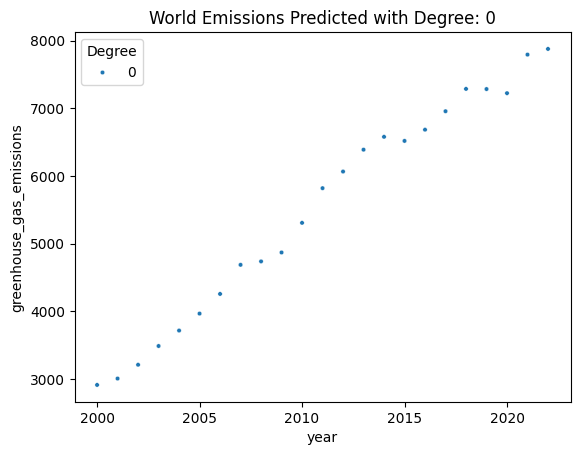

In [32]:
# load libraries for bokeh
from ipywidgets import Button, VBox, interactive_output
from IPython.display import display as dp1
from IPython.display import clear_output as co

# Function to update the plot
def printPlot(regressor = 0):
  co(wait=True)
  dp1(VBox([buttonNone, button1, button2, button3, button4, buttonDNN, buttonBest]))
  zero = '0'
  sns.scatterplot(x='year',                       # X-axis - label must match that of the df
                  y='greenhouse_gas_emissions',   # Y-axis - label must match that of the df
                  hue='Degree',
                  s=10,
                  data=world_emissions.query('Degree == @zero or Degree == @regressor'))
  plt.title(f"World Emissions Predicted with Degree: {regressor}")
  plt.show()

# Make the buttons
buttonNone = Button(description="Default")
button1 = Button(description="Linear")
button2 = Button(description="Quadratic")
button3 = Button(description="Cubic")
button4 = Button(description="Quartic")
buttonDNN = Button(description="DNN")
buttonBest = Button(description="Best")

# Handle Functions for Button Presses
def onButtonNoneClicked(b):
  printPlot('None')

def onButton1Clicked(b):
  printPlot('1')

def onButton2Clicked(b):
  printPlot('2')

def onButton3Clicked(b):
  printPlot('3')

def onButton4Clicked(b):
  printPlot('4')

def onButtonDNNClicked(b):
  printPlot('DNN')

def onButtonBestClicked(b):
  printPlot('Best')

# Assign Handles
buttonNone.on_click(onButtonNoneClicked)
button1.on_click(onButton1Clicked)
button2.on_click(onButton2Clicked)
button3.on_click(onButton3Clicked)
button4.on_click(onButton4Clicked)
buttonDNN.on_click(onButtonDNNClicked)
buttonBest.on_click(onButtonBestClicked)

printPlot()

In [33]:
'''
This is great, now we can produce the regressions for all the countries and sum them without error. At this point we need to do 3 things.
  1) Calculate the regression with a DNN - done
  2) Determine which regression is best using R2 value & have a best regression which sums the best fit regressions
  3) Put this into a Bokeh environment to allow the user to toggle between linear, quadratic, cubic, quartic, DNN, Best, and All
  4) Build & print a decision tree which classifies developing and developed countries based on their characteristics
'''

'\nThis is great, now we can produce the regressions for all the countries and sum them without error. At this point we need to do 3 things.\n  1) Calculate the regression with a DNN - done\n  2) Determine which regression is best using R2 value & have a best regression which sums the best fit regressions\n  3) Put this into a Bokeh environment to allow the user to toggle between linear, quadratic, cubic, quartic, DNN, Best, and All\n  4) Build & print a decision tree which classifies developing and developed countries based on their characteristics\n'

In [34]:
from sklearn.model_selection import KFold
import math
from sklearn.metrics import mean_squared_error as mse



In [ ]:
# data analysis to confirm the fits of regressions with RMSE, K fold and R2 - has some difficulty if the data is not processed correctly (adding best and DNN to degrees messes things up - run this before then)
rg = LinearRegression()
dfn = workingData.drop([ 'country', 'Regression'], axis = 1)
dfn0 = dfn.fillna(0) #or whatever
preprocessing.normalize(dfn0)
quancol = [ 'country', 'Regression']
quan = workingData[quancol]
current_data = quan.join(dfn0)
#normalized to see if that was a problem....wasn't
for c in current_data['country'].unique():

  best_degree = 0
  current_df = current_data[(workingData.country == c) & (workingData.Regression == False)]
  #made sure to ignore predicted values
  current_df = current_df.dropna(subset = 'greenhouse_gas_emissions')
  #the current rmse for this country
  lowest_rmse = 10000000
  #yy is the original..to make sure the degree doesn't compound
  yy = current_df['greenhouse_gas_emissions']

  x = current_df[ 'year']
  x = np.array(x).reshape(-1,1)
  #want to find the best degree for each country
  for degree in [1, 2, 3, 4, (1/2), (1/4), (1/3)]:
  #weird order to see if it just picks the last one...doesn't

    #make the data match the degree
    k = 6
    count = 0
    total = 0
    k_folds = KFold(n_splits = k, shuffle = True, random_state = 1 )

    y = np.power(yy, degree)
    total_rmse = 0
    count = 0
    av = 0
    #find generally the rmse for this degree
    for train_index, test_index in k_folds.split(x):
      x_train, x_test = x[train_index, :], x[test_index, :]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      y_train.fillna(0)
      rg.fit(x_train, y_train.fillna(0))
      pred = rg.predict(x_test)
      #true, pred
      curr_rmse = math.sqrt(mse(y_test.fillna(0), pred))
      total_rmse = total_rmse + curr_rmse
      count = count + 1
  #this is the rmse for this degree
    av = total_rmse/count

  #if it's the lowest out of the rmses for the degree so far...
    if av < lowest_rmse:
      lowest_rmse = av
      best_degree = degree

  #print(c, best_degree)

for c in current_data['country'].unique():

  best_degree = 0
  current_df = current_data[(workingData.country == c) & (workingData.Regression == False)]
  #made sure to ignore predicted values
  current_df = current_df.dropna(subset = 'greenhouse_gas_emissions')
  #the current rmse for this country
  lowest_rmse = 10000000
  #yy is the original..to make sure the degree doesn't compound
  yy = current_df['greenhouse_gas_emissions']
  yy_std = yy.std
  yy_av = yy.mean
  x = current_df[ 'year']
  x = np.array(x).reshape(-1,1)
  y = np.power(yy, .25)
  fit = rg.fit(x, y)
  xx = [2023, 2024, 2025, 2026]
  xx = np.array(xx)
  xx = xx.reshape(-1, 1)
  pred = rg.predict(xx)
  print(c)
  #print(pred)





In [ ]:
for c in workingData['country'].unique():
   current_df = workingData[(workingData.country == c) & (workingData.Regression == False)]
   current_df = current_df.dropna(subset = 'greenhouse_gas_emissions')
   yy = current_df['greenhouse_gas_emissions']
   x = current_df[ 'year']

In [ ]:
display(workingData)

In [ ]:
display(world_emissions)